In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import tensorflow as tf
import metrics as mymetrics
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from tensorflow import keras
from joblib import dump, load
%matplotlib inline

# CS5600 Final Project by Jeff Gradner
***
### About
The goal of this project and notebook is to compare the performance of supervised and unsupervised machine learning techniques in classifying whether treatment of an animal will be successful. The data I'm using can be found in `data/raw_data.csv` and is provided by a Utah feedlot operation.
***
### Preprocesing
I'll preprocess the data by adding calculated features, removing features, and performing feature engineering by normalization and standardization. 
***
### Visualization
I'll use Matplotlib to visualize and gain insight from the raw data, processed data and results from different algorithms.
***
### Algorithms
I'll use a variety of different techniques and apply cross-validation and hyperparameter tuning where applicable:
#### Supervised
* Random Forests (RF)
* AdaBoost
* Support Vector Machines (SVM)
* Logistic Regression
* Neural Networks (NN)

#### Unsupervised
* Gaussian Mixed Models (GMM)
* K-Means (KMeans)
* Primary Component Analysis (PCA)
* Kernel Primary Component Analysis (KPCA)
***
### Table of Contents

* [Raw Data Visualization](#rawDataVis)
* [Pre Processing](#preprocessing)
* [Splitting the Data](#splitting)
* [Supervised Algorithms](#supervised) 
    * [Random Forest](#rf)
    * [AdaBoost](#ada)
    * [Support Vecor Machine](#svm)
    * [Logistic Regression](#lr)
    * [Neural Network](#nn)
* [Unsupervised Algorithms](#unsupervised)
    * [Gaussian Mixed Models](#gmm)
    * [K-Means](#kmean)
    * [Primary Component Analysis](#pca)
    * [Kernel Primary Component Analysis](#kpca)
* [ROC Curves](#roc)

<a id="rawDataVis"></a>
# Raw Data Visualization

Below I'm reading the original data into a Pandas DataFrame and assign the dtype to each column based on observing the data in a spreadsheet.

In [ ]:
df_raw = pd.read_csv('data/raw_data.csv', dtype={'yard.lot.tag.date':'object',
                                                            'Yard.Lot': 'object',
                                                            'yard.lot.tag':'object',
                                                            'Yard': 'string',
                                                            'Lot': 'string',
                                                            'Treat.Date':'string',
                                                            'Drug': 'string',
                                                            'Treat.Weight':'int64',
                                                            'Treat.Temperature':'float64',
                                                            'Sex': 'string',
                                                            'Treatment.Number':'int64',
                                                            'Head.Received': 'int64',
                                                            'Arrival.Date': 'string',
                                                            'Arrival.Weight':'float64',
                                                            'Death.Date':'object',
                                                            'Cause.Of.Death':'object'},)

## Plotting of the Raw Data

### Quantity of Deaths by Cause per Gender
I see that both male and female cows die majorily from respiratory problems and that more males die than females. H is for hefer and S is for steer.

In [ ]:
plt.figure(figsize=(12,12))
sns.countplot(x='Sex', hue ='Cause.Of.Death', data=df_raw)
plt.title('Causes of Death per Gender')
plt.legend(loc='best')
plt.show()

## Quantity of Causes of Death per Drug Type
I'm checking for the the largest causes of death, RESPIRATORY, AIP, and OTHER, how many die while being treated with a given drug. 

Below I'm filtering the data to only include examples where the cause of death is one of the 3 top contributors.

In [ ]:
df_respiratory = df_raw.loc[df_raw['Cause.Of.Death'] == 'RESPIRATORY']
df_aip = df_raw.loc[df_raw['Cause.Of.Death'] == 'AIP']
df_other = df_raw.loc[df_raw['Cause.Of.Death'] == 'OTHER']
df_deaths_drugs = pd.concat([df_respiratory, df_aip, df_other], axis=0)

Plotting the number of deaths for each cause of death and with what treatment drug was used.

In [ ]:
plt.figure(figsize=(28,16))
sns.countplot(x='Cause.Of.Death', hue ='Drug', data=df_deaths_drugs)
plt.title('Causes of Death per Treament Drug',fontsize=15)
plt.legend(loc='upper right',prop={'size':'15'})
plt.xlabel('Drug', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.show()

## Raw Data Insights

Below is the shape of the original data and a sample of 3 examples.

In [ ]:
print("Original data shape:", df_raw.shape)
df_raw.sample(3)

I'm checking if there are any null values and how many of each there are. I see that there are missing values for the Death Date and Cause of Death, this makes sense because not every animal who is treated for Bovine Respiratory Disease dies.

In [ ]:
df_raw.isna().sum()

Checking how many deaths per Cause of Death. The majority of deaths reported are attributed to respiratory.

In [ ]:
df_raw['Cause.Of.Death'].value_counts()

Viewing how many of each sex exist in the data. 

In [ ]:
df_raw['Sex'].value_counts()

Viewing descriptive statistics from the original data.

In [ ]:
df_raw.describe().T

<a id="preprocessing"></a>
# Pre-Processing

In [ ]:
df_raw.sample(3)

Feedlots are made up of yards that contain lots where the animals reside. Each animal has a unique tag. Below I'm taking the series of yard.lot.tag and splitting the data where there are periods to create three series for the yard, lot, and tag. I'm then combining yard and tag into one series named Yard.Tag adding it to the DataFrame and removing the yard and tag columns.

In [ ]:
ylt = df_raw['yard.lot.tag']
ylt = ylt.str.split( '.', expand= True)
ylt.rename(columns = {0:'yard', 1:'lot', 2:'tag'}, inplace = True)
df_raw['yard'] = ylt['yard']
df_raw['tag'] = ylt['tag']
df_raw['Yard.Tag'] = df_raw['yard'] + '.' + df_raw['tag']
df_raw = df_raw.drop(['yard', 'tag'], axis = 1)

A target column doesn't exist in the raw data so I'm going to add one named DNF for Did Not Finish. If an example has 0 for its DNF value then the animal finished or lived. If DNF has a value of 1 then that animal died. I construct the DNF series by inserting the value 0 if there is no death date, otherwise 1.

In [ ]:
df_raw['DNF'] = ''
df_raw['DNF'] = np.where(pd.isna(df_raw['Death.Date']), 0, 1)

Thinking that the time of year an animal arrives on the feedlot and gets sick could be useful I'm adding features for the arrival month and quarter, and the treat month and quarter. I'm using Pandas to parse the month and quarter from the exising arrival and treat dates. 

In [ ]:
df_raw['Arrival.Month'] = pd.DatetimeIndex(df_raw['Arrival.Date']).month
df_raw['Arrival.Quarter'] = pd.DatetimeIndex(df_raw['Arrival.Date']).quarter
df_raw['Treat.Month'] = pd.DatetimeIndex(df_raw['Treat.Date']).month
df_raw['Treat.Quarter'] = pd.DatetimeIndex(df_raw['Treat.Date']).quarter

There will be examples that have the same Yard.Lot if they are treated more than once or are treated once and do not finish. I want all instances for a particular animal to reflect whether they died or not. For example if an animal is treated two times and there is a third input vector that reflects that the animal died then I want all of the instances for that animal to have a DNF value of 1. Below I sort the raw data by Yard.Lot and Treat.Date, I then get a boolean series where examples that have a dupilcate are marked True. These examples that are marked True reflect the cows that need to have their DNF values updated to match the end result for that animal. I then access the raw data with the boolean series and group by the Yard.Lot and Yard.Tag meaning I'm grouping all instances for each unique animal. I then access those groups at their DNF values and apply transform to each group so that if there is a value 1 in any of a groups DNF then all will have the value 1 for DNF. This returns a boolean series where True indicates that all the values were set to 1 and False means the cow finished and all examples for that cow have a DNF of 0. I used this boolean series to update the DNF column as integers 0 or 1.

In [ ]:
df_raw = df_raw.sort_values(['Yard.Lot', 'Treat.Date'])
dup = df_raw.duplicated(['Yard.Lot', 'Yard.Tag'], keep=False)
fixed_dnf = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['DNF'].transform(any)
df_raw['DNF'].update(fixed_dnf.astype(int))

Similar to how I want the DNF value to be the same for all examples given a single unique animal I want the death date and cause of death to match for all examples of an animal. Below I use the boolean series `dup` from above which indicated which examples have duplicates or which animals have more than entry in the data. I then group by Yard.Lot and Yard.Tag again where each group consists of examples for a single animal and take the animal death date and fill backwards from the example so that all entries for a single animal have the same death date and then also fill forwards to ensure that any entries after the one marked with the death date also have the death date value. I repeat this process for the cause of death.  

In [ ]:
death_date_fixed1 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Death.Date'].fillna(method='bfill')
df_raw['Death.Date'].update(death_date_fixed1)
death_date_fixed2 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Death.Date'].fillna(method='ffill')
df_raw['Death.Date'].update(death_date_fixed2)

death_cause_fixed1 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Cause.Of.Death'].fillna(method='bfill')
df_raw['Cause.Of.Death'].update(death_cause_fixed1)
death_cause_fixed2 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Cause.Of.Death'].fillna(method='ffill')
df_raw['Cause.Of.Death'].update(death_cause_fixed2)

So far all of the examples represent a treatment of a given animal and I want to make sure that the treatment number is correct for all examples. I again use the boolean series dup to get all the instances where they belong to an animal who have more than one entry in the data and group by the Yard.Lot and Yard.Tag and number each item in each group $0$ to $(len(group)-1)$ with Pandas cumcount() function. A treament number wouldn't ever be 0 the first treatment should have a treatment number of 1 so I increment all the values by 1. Finally the Treatment.Number column is replaced with the updated treatment number values.

In [ ]:
fixed_treat = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag']).cumcount()
fixed_treat += 1
df_raw['Treatment.Number'] = fixed_treat

Adding a new row for the death event of each animal if they did not finish. I'm creating a DataFrame of all the examples where the death date is not null and dropping and duplicates of Yard.Lot and Yard.Tag so that the data has one example for each animal that did not finish. Set the treat date equal to the death date because these rows are the death event not a treatment instance. I also set the drug, treat weight, and treat temperature to null (nan). 

In [ ]:
df_dnf = df_raw.loc[df_raw['Death.Date'].notna()].drop_duplicates(['Yard.Lot', 'Yard.Tag'])
df_dnf['Treat.Date'] = df_dnf['Death.Date']
df_dnf.loc[:,['Drug', 'Treat.Weight','Treat.Temperature']] = np.nan

Concatenating the death events to the raw data and sorting by Yard.Lot and Treat.Date to observe if it looks correct. It does and then I reset the index after sorting the DataFrame.

In [ ]:
df = pd.concat([df_raw, df_dnf], ignore_index=True)
df = df.sort_values(['Yard.Lot', 'Treat.Date'])
df = df.reset_index(drop=True)

Adding another feature Brdcasestothispoint that is the number of BRD cases in a given lot for each example. 

In [ ]:
df.loc[:,'Brdcasestothispoint'] = df.groupby(df['Yard.Lot']).cumcount()

Adding another feature that is the number of distinct cases of BRD for a given lot.

In [ ]:
unique_cases = df.drop_duplicates(['Yard.Lot', 'Yard.Tag']).groupby(df['Yard.Lot']).cumcount()
distbrd = unique_cases.reindex(df.index).ffill().astype(int)
df['Distbrdcasestothispoint'] = distbrd

Adding two more features, one for the total treatment failures and another for the treatment failures for a given lot

In [ ]:
dup = df.duplicated(['Yard.Lot', 'Yard.Tag'])
df['Txfailure2'] = dup.astype(int)
failtothispoint = df.groupby(df['Yard.Lot']).cumsum()['Txfailure2']
df['Txfailure2tothispoint'] = failtothispoint

Adding another feature that is the treatment success rate for a given lot. 

In [ ]:
success_rate = (df['Distbrdcasestothispoint']-df['Txfailure2tothispoint'])/df['Distbrdcasestothispoint']
success_rate = success_rate.fillna(1)
success_rate = success_rate.replace(np.NINF, 1)
success_rate = success_rate.replace(np.inf, 1)
df['Txsuccessrate2'] = success_rate

Adding two more features, one for the proportion of BRD cases and another for the proportion of distinct BRD cases for a given lot. 

In [ ]:
df['Propbrdcasestothispoint'] = df['Brdcasestothispoint']/df['Head.Received']
df['Propdistcasestothispoint'] = df['Distbrdcasestothispoint']/df['Head.Received']

Adding a days since arrival feature to determine how long the animal has been in the feedlot.

In [ ]:
df['Dayssincearrival'] = (pd.to_datetime(df['Treat.Date'])-pd.to_datetime(df['Arrival.Date'])).dt.days

Adding two more features, the amount of deaths and the proportion of deaths.

In [ ]:
dnf = df.loc[df['Death.Date'].notna()]
deathcount = df.groupby(df['Yard.Lot'])['DNF'].cumsum()
df['Deathstothispoint'] = deathcount
df['Propdeathstothispoint'] = df['Deathstothispoint']/df['Head.Received']

Adding two more features, the number of animals that were pulled and treated on a given day for a lot and the proportion of pulls for that lot. 

In [ ]:
df['Dailyallpulls'] = df.groupby(['Yard.Lot', 'Treat.Date'])['Treat.Date'].transform('size')
df['Propdailyallpulls'] = df['Dailyallpulls']/df['Head.Received']

Viewing a sample of the data.

In [ ]:
df.sample(3)

Dropping columns from the data I won't use or need.

In [ ]:
df_reduced = df.drop(['yard.lot.tag.date','Yard', 'Yard.Lot','yard.lot.tag', 'Lot', 'Arrival.Date','Yard.Tag','Treat.Date', 'Death.Date', 'Cause.Of.Death'], axis=1)

Creating a dataset with no one hot encoding for dimesionality reduction algorithms.

In [ ]:
no_one_hot = df_reduced.copy()

One hot encoding nominal features and viewing a sample of the data.

In [ ]:
df_one_hot = pd.get_dummies(data=df_reduced, columns=['Arrival.Month', 'Arrival.Quarter', 'Treat.Month', 'Treat.Quarter', 'Drug', 'Sex'])
pd.set_option('display.max_columns', 79)
df_one_hot.sample(5)

Filtering out the numeric features for feature engineering and viewing a sample.

In [ ]:
numeric_features = df_one_hot.drop(df_one_hot.iloc[:,17:], axis=1)
numeric_features.drop(columns=['DNF'], axis=1, inplace=True)
numeric_features.sample(5)

Statistical details of the numeric features.

In [ ]:
numeric_features.describe().T

Checking for null or missing data from the numeric features.

In [ ]:
numeric_features.isna().sum()

Filling missing data with the mean of the feature it belongs to. The mean doesn't tell us anything statisically speaking

In [ ]:
numeric_features['Treat.Weight'].fillna(value=numeric_features['Treat.Weight'].mean(), inplace=True)
numeric_features['Treat.Temperature'].fillna(value=numeric_features['Treat.Temperature'].mean(), inplace=True)
numeric_features['Treatment.Number'].fillna(value=numeric_features['Treatment.Number'].mean(), inplace=True)

no_one_hot['Treat.Weight'].fillna(value=no_one_hot['Treat.Weight'].mean(), inplace=True)
no_one_hot['Treat.Temperature'].fillna(value=no_one_hot['Treat.Temperature'].mean(), inplace=True)
no_one_hot['Treatment.Number'].fillna(value=no_one_hot['Treatment.Number'].mean(), inplace=True)

Using scikit-learn I'm going to normalize and standardize the numeric features. I'll create two datasets so that I can use the scaled or nomalized data depending on the algorithm. I'm storing the numeric feature column names so I can reconstruct a DataFrame with the transformed datasets.

In [ ]:
numeric_column_labels = numeric_features.columns
normed_features = preprocessing.normalize(numeric_features)
df_normed = pd.DataFrame((normed_features), columns=numeric_column_labels)
scaled_features = preprocessing.scale(numeric_features)
df_scaled = pd.DataFrame((scaled_features), columns = numeric_column_labels)

Combining the transformed data from above with the nominal features that were one-hot encoded and saving them to CSV files.

In [ ]:
normed_processed = pd.concat([df_normed, df_one_hot.iloc[:,17:], df_reduced['DNF']], axis=1, sort=False)
scaled_processed = pd.concat([df_scaled, df_one_hot.iloc[:,17:], df_reduced['DNF']], axis=1, sort=False)
normed_processed.to_csv('data/normed_processed_data.csv', index=False)
scaled_processed.to_csv('data/scaled_processed_data.csv', index=False)

In [ ]:
dnf_tmp = no_one_hot["DNF"]
no_one_hot = no_one_hot.drop(("DNF"), axis=1)

In [ ]:
no_one_hot["Drug"] = no_one_hot["Drug"].astype('category').cat.codes

In [ ]:
no_one_hot = pd.concat((no_one_hot, dnf_tmp), axis=1)

In [ ]:
no_one_hot["Sex"] = no_one_hot["Sex"].astype('category').cat.codes

In [ ]:
no_one_hot.to_csv('data/no_one_hot_data.csv', index=False)

<a id="splitting"></a>
# Splitting the Data

Splitting the data into a training, validation and testing set with scikit-learn. Below I store the targets in a flattened array named target.

In [8]:
df_normed = pd.read_csv('data/normed_processed_data.csv')
df_scaled = pd.read_csv('data/scaled_processed_data.csv')

In [9]:
target_n = df_normed[['DNF']]
target_s = df_scaled[['DNF']]

Splititng the normalized data into a training and testing set with an 80-20 split.

In [10]:
x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(df_normed.iloc[:, :-1], 
                                                    target_n, 
                                                    test_size = 0.3, 
                                                    random_state=8)
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(df_scaled.iloc[:, :-1], 
                                                    target_s, 
                                                    test_size = 0.3, 
                                                    random_state=8)

Splitting the training data into a training and validation sets with a 85-15 split.

In [11]:
x_train_n, x_val_n, y_train_n, y_val_n = train_test_split(x_train_n, 
                                                  y_train_n, 
                                                  test_size=0.2,
                                                  random_state=10)
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(x_train_s, 
                                                  y_train_s, 
                                                  test_size=0.2,
                                                  random_state=10)

Displaying the size of each dataset.

In [12]:
print("Train Inputs Shape:", x_train_n.shape, "| Val Inputs Shape:", x_val_n.shape, "| Test Inputs Shape:", x_test_n.shape)
print("Train Target Shape:", y_train_n.shape, " | Val Target Shape:", y_val_n.shape, " | Test Target Shape:", y_test_n.shape)

Train Inputs Shape: (389600, 71) | Val Inputs Shape: (97401, 71) | Test Inputs Shape: (208715, 71)
Train Target Shape: (389600, 1)  | Val Target Shape: (97401, 1)  | Test Target Shape: (208715, 1)


<a id="supervised"></a>
# Supervised Algorithms 

<a id="rf"></a>
## Random Forests
From scikit-learn I'm going to use Random Forests. Below I create a list of possible values for the number of estimators to consider.

In [7]:
N = np.arange(100,251,step=50)

Using cross-validation to determine the best number of esimators. For every value n in N I instantiate the Random Forest Classifier from scikit-learn, fit the model with the training data, then compute the accuracy and error of the model on the validation data.

In [8]:
starttime = time.time()
rf_models = []
rf_val_errors = []
for n in N:
    rf = RF(n_estimators=n, n_jobs=6)
    rf.fit(x_train_s.values, y_train_s.values.ravel())
    rf_models.append(rf)
    rf_val_errors.append(1 - rf.score(x_val_s.values, y_val_s.values))
print('Training took:', time.time() - starttime, 'seconds')

Training took: 133.39618349075317 seconds


Plotting the validation error vs. the number of estimators used. The error $E$ is calculated as $E = 1 - $accuracy.

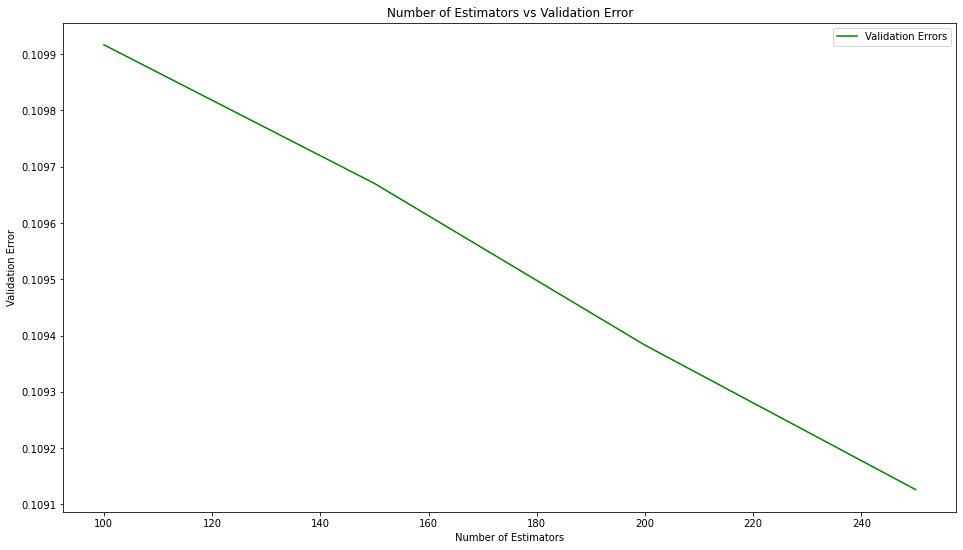

In [9]:
plt.figure(figsize=(16,9))
plt.plot(N,rf_val_errors, 'g-', label='Validation Errors')
plt.xlabel('Number of Estimators')
plt.ylabel('Validation Error')
plt.title('Number of Estimators vs Validation Error')
plt.legend()
plt.show()

Below I'm observing the index that corresponds to the minimum validation error and storing that model in the variable `rf`.

In [13]:
idx = np.argmin(rf_val_errors)
rf = rf_models[2]

The model produced with 250 estimators produced the lowest validation error.

In [14]:
N[idx]

250

Printing results of the Random Forest model being evaluated on the test data.

In [18]:
mymetrics.print_metrics(mymetrics.get_metrics(rf, x_test_s, y_test_s, 'Untuned RF'))

name: 

Untuned RF 

cm: 

actual       0      1
pred                 
0       156702  19291
1         3525  29197 

specificity: 

0.9779999625531277 

sensitivity: 

0.6021489853159545 

precision: 

0.8922743108611944 

accuracy: 

0.8906834678868313 



The training performed pretty slowly so I'm attempting to speed up the training process by reducing the number of samples to be drawn in each bootstrap sample from the total number of examples to 10%, 30%, and 50% of the total number of examples. I'm going to build the model with 250 estimators still and compare the results to the confusion matrix above.

In [19]:
sample_sizes = [.1, .3, .5]

Below I am observing the validation errors produced from models fit with the train data and evaluated on the validation data. Three models are built each with 250 trees in the forest and with bootstrap sample sizes of 10%, 20%, and 30% respectively.

In [21]:
starttime = time.time()
models = []
val_errors = []
for s in sample_sizes:
    rf_smaller_bs_samples = RF(n_estimators=250, n_jobs=4, max_samples=s)
    rf_smaller_bs_samples.fit(x_train_s.values, y_train_s.values.ravel())
    models.append(rf_smaller_bs_samples)
    val_errors.append(1 - rf_smaller_bs_samples.score(x_val_s.values, y_val_s.values))
print('Training took:', time.time() - starttime, 'seconds')

Training took: 68.89317798614502 seconds


Below I observe that the model built with bootstrapped samples having 50% of the total number of examples resulted in the lowest validation error.

In [22]:
idx = np.argmin(val_errors)
sample_sizes[idx]

0.5

Based on the plot below I'm going to use sample sizes of 50% the total number of examples.

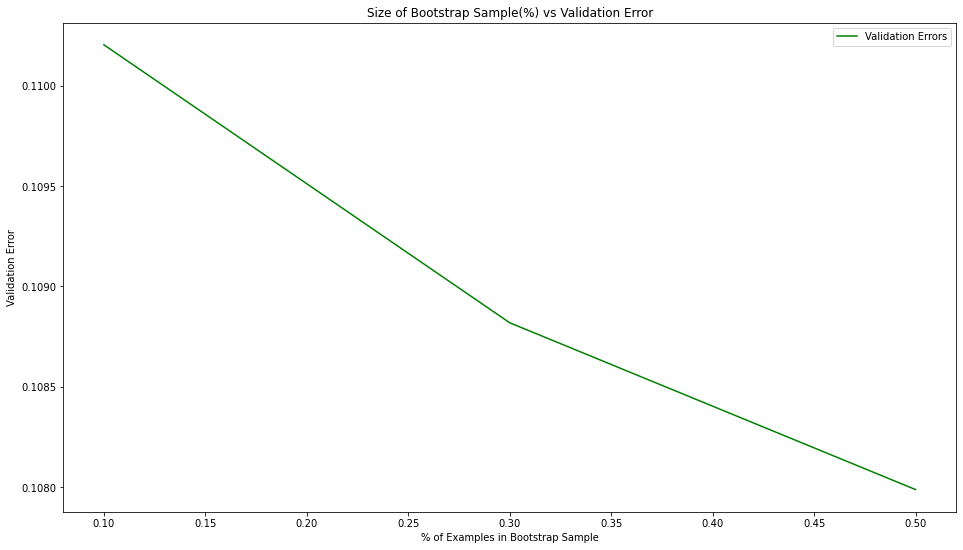

In [23]:
plt.figure(figsize=(16,9))
plt.plot(sample_sizes,val_errors, 'g-', label='Validation Errors')
plt.xlabel('% of Examples in Bootstrap Sample')
plt.ylabel('Validation Error')
plt.title('Size of Bootstrap Sample(%) vs Validation Error')
plt.legend()
plt.show()

The confusion matrix result from evaluating the model built with 250 estimators and bootstrap samples having 50% of the total number of examples in the train data. The confusion matrix appears to have better results than using $N$ examples in the bootstrap samples where $N$ is the number of examples in the train data.

In [24]:
mymetrics.print_metrics(mymetrics.get_metrics(models[idx], x_test_s, y_test_s, 'Sample Size Tuned RF'))

name: 

Sample Size Tuned RF 

cm: 

actual       0      1
pred                 
0       157341  19858
1         2886  28630 

specificity: 

0.9819880544477523 

sensitivity: 

0.5904553704009239 

precision: 

0.9084274654143927 

accuracy: 

0.8910284359054212 



Checking the specificity of the model and it is better than that of the earlier model with larger bootstrap samples.

Below I'm testing how long the training takes with 250 trees in the forest and sample sizes of $(0.50 \cdot N)$ where N is the total number of examples in the train set. 

In [25]:
starttime = time.time()
rf = RF(n_estimators=250, max_samples=.5, n_jobs=1)
rf.fit(x_train_s.values, y_train_s.values.ravel())
print('Training took:', time.time() - starttime, 'seconds')

Training took: 104.57492327690125 seconds


We can see that by increasing the number of jobs to run in parallel from 1 to 4 increased the time by $104.6 - 27.9 = 76.7$ seconds. I've updated training above to use more threads to decrease the time it takes when I re-run the notebook. 

In [26]:
starttime = time.time()
rf = RF(n_estimators=250, max_samples=.5, n_jobs=6)
rf.fit(x_train_s.values, y_train_s.values.ravel())
print('Training took:', time.time() - starttime, 'seconds')

Training took: 27.88589310646057 seconds


I'm now going to tune the max depth of the trees that make up the forest.

In [9]:
max_depths = [50, 100, 150, 200, 350]

Below I store the validation errors for models built with tree max depths of 50, 100, 250, 500, and 2000. I can compare the results to the confusion matrix and specificity above where the model was built with no max depth specified. Each model below is built with 250 estimators and sample sizes of 30% the total number of examples.

In [10]:
starttime = time.time()
models = []
val_errors = []
for d in max_depths:
    rf_max_depths = RF(n_estimators=250, n_jobs=6, max_samples=.50, max_depth=d)
    rf_max_depths.fit(x_train_s.values, y_train_s.values.ravel())
    models.append(rf_max_depths)
    val_errors.append(1 - rf_max_depths.score(x_val_s.values, y_val_s.values))
print('Training took:', time.time() - starttime, 'seconds')

Training took: 142.37521052360535 seconds


Plotting the Tree Max Depth vs. the Validation Error. Based on the plot below I'm selecting a max depth of 50 as the model built with 50 for the max depth produced the lowest validation error.

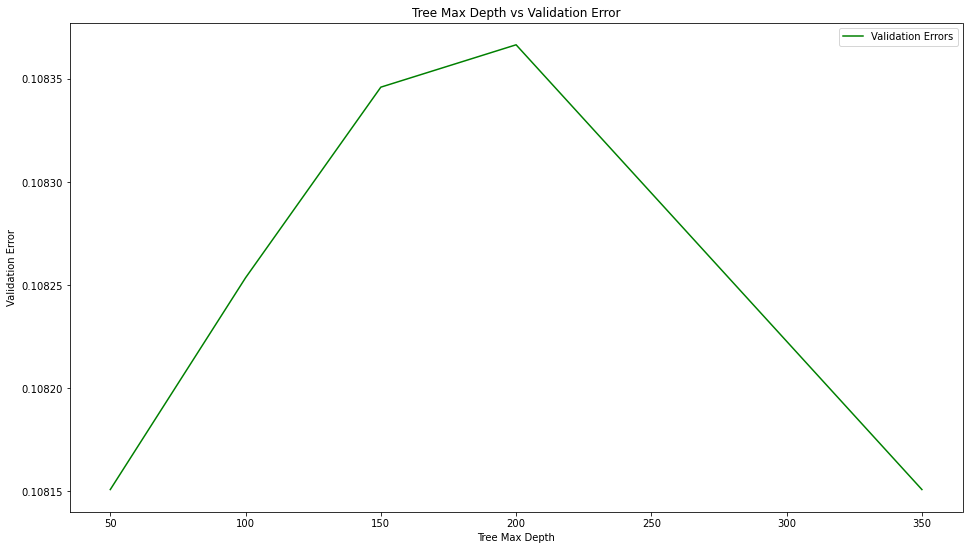

In [11]:
plt.figure(figsize=(16,9))
plt.plot(max_depths,val_errors, 'g-', label='Validation Errors')
plt.xlabel('Tree Max Depth')
plt.ylabel('Validation Error')
plt.title('Tree Max Depth vs Validation Error')
plt.legend()
plt.show()

Evaluating the tuned model on the test data.

In [12]:
# clf = load('fit-models/random-forest.joblib')
rf_metrics = mymetrics.get_metrics(models[0], x_test_s, y_test_s, 'Final RF')
mymetrics.print_metrics(rf_metrics)

Name: Final RF
cm: 



actual,0,1
pred,,
0,157423,19870
1,2804,28618


'\n'

Specificity: 

0.9824998283685021 

Sensitivity: 

0.5902078864873783 

Precision: 

0.9107631595697282 

Accuracy: 

0.8913638214790504 



In [16]:
dump(models[0], 'fit-models/random-forest.joblib')

['fit-models/random-forest.joblib']

Memory Issues with
RBF Net
Kernel PCA


<a id="ada"></a>
## AdaBoost

Creating a list named `eta` of possible learning rates.

In [13]:
eta = np.arange(0.1,1.5,step=.2)

Empty lists to store the various models and their validation errors. I'll be observing the validation error of models trained with the different learning rates defined above.

In [14]:
ada_models = []
ada_val_errors = []

Using cross-validation to determine the best learning rate. I'm observing the error produced from models trained with different learning rates to find the best learning rate for this data. 

In [16]:
starttime = time.time()
for e in eta:
    ada = AdaBoost(learning_rate=e, random_state=10)
    ada.fit(x_train_s.values, y_train_s.values.ravel())
    ada_models.append(ada)
    ada_val_errors.append(1 - ada.score(x_val_s.values, y_val_s.values.ravel()))
print('Training took:', time.time() - starttime, 'seconds')

Training took: 174.4853196144104 seconds


Plotting the learning rates vs the errors produced from evaluating the model on the validation data. From the error values I used above it looks like 1.3 produces the lowest validation error.

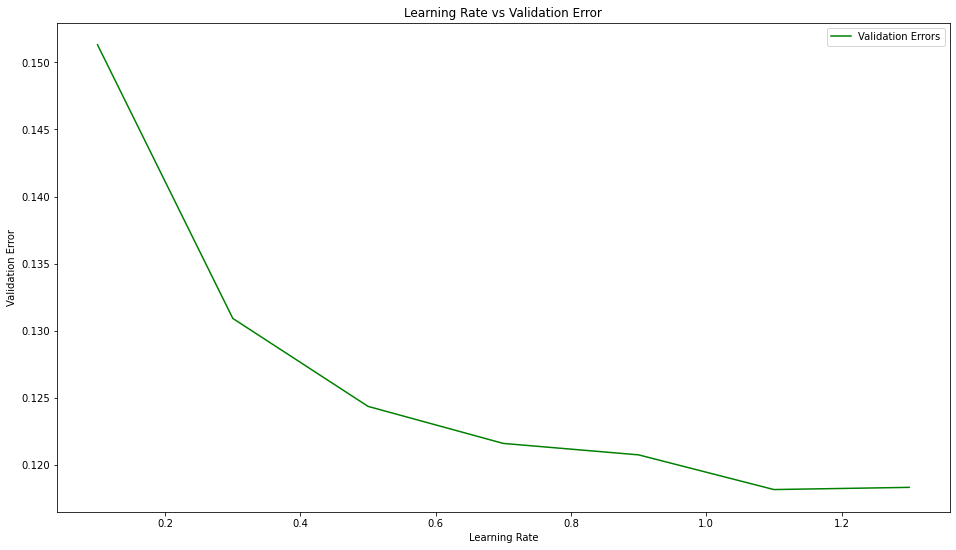

In [17]:
plt.figure(figsize=(16,9))
plt.plot(eta,ada_val_errors, 'g-', label='Validation Errors')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Error')
plt.title('Learning Rate vs Validation Error')
plt.legend()
plt.show()

Getting the model built with a learning rate of 1.1

In [18]:
idx = np.argmin(ada_val_errors)
ada = ada_models[idx]

The learning rate used that produced the lowest validation error is 1.1

In [19]:
eta[idx]

1.1000000000000003

Evaluating the AdaBoost model, trained with a learning rate of 1.1, on the test data.

In [20]:
mymetrics.print_metrics(mymetrics.get_metrics(ada, x_test_s, y_test_s, 'Learning Rate Tuned AdaBoost'))

Name: Learning Rate Tuned AdaBoost
Cost Matrix: 



actual,0,1
pred,,
0,156112,20684
1,4115,27804


Specificity: 

0.9743176867818782 

Sensitivity: 

0.5734202276852005 

Precision: 

0.8710799210501582 

Accuracy: 

0.8811824737081666 



Tuning the number of max estimators used. The default value for max estimators is 50 so by increasing the value I could improve the performance and it could also increase the chance of overfitting. I'll choose the value for max estimators that produces the lowest validation error and evaluate that model against the test data. I can then compare the results with those listed just above as the results above are from a model built with the default value for max estimators, 50. 

In [22]:
n_estimators = [100,200,500,1000,2000]
models = []
val_errors = []
starttime = time.time()
for n in n_estimators:
    ada = AdaBoost(learning_rate=1.1, random_state=10, n_estimators=n)
    ada.fit(x_train_s.values, y_train_s.values.ravel())
    models.append(ada)
    val_errors.append(1 - ada.score(x_val_s.values, y_val_s.values.ravel()))
print('Training took:', time.time() - starttime, 'seconds')

Training took: 1853.7832219600677 seconds


Plotting the values used for the number of max estimators against the validation errors. 

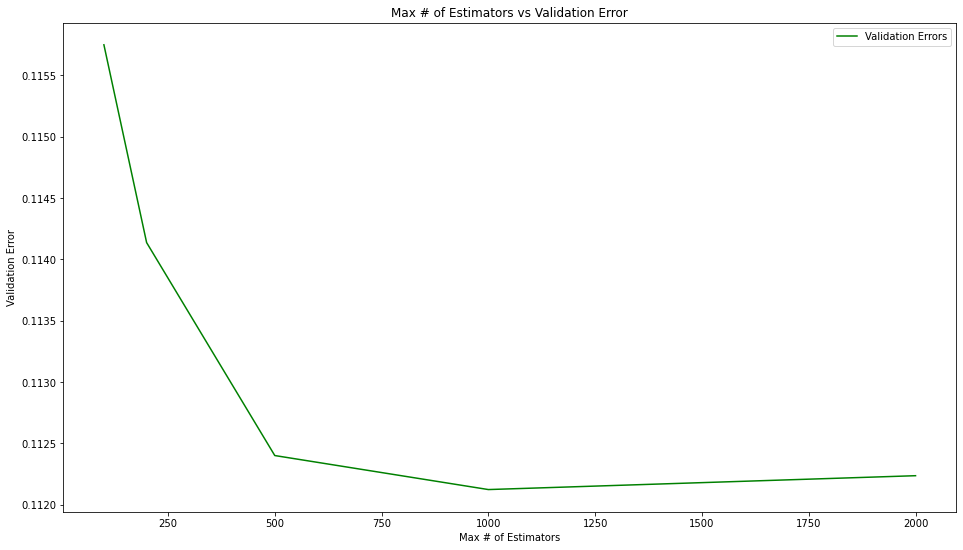

In [23]:
plt.figure(figsize=(16,9))
plt.plot(n_estimators,val_errors, 'g-', label='Validation Errors')
plt.xlabel('Max # of Estimators')
plt.ylabel('Validation Error')
plt.title('Max # of Estimators vs Validation Error')
plt.legend()
plt.show()

Based on the plot above I'm selecting the model that had 1000 for the max number of estimators and evaluating it against the test data. Below I show the metrics produced from evaluating the model on the test data.

In [24]:
ada = models[3]
mymetrics.print_metrics(mymetrics.get_metrics(ada, x_test_s, y_test_s, 'Learning Rate Tuned AdaBoost'))

Name: Learning Rate Tuned AdaBoost
Cost Matrix: 



actual,0,1
pred,,
0,156018,19350
1,4209,29138


Specificity: 

0.9737310191166283 

Sensitivity: 

0.6009321894076886 

Precision: 

0.873781749482712 

Accuracy: 

0.8871235895838824 



The model didn't perform better than the one built with a max number of estimators at the default of 50. It produced a better accuracy but smaller specificity, this is likely due to overfitting from allowing too many estimators. I'm going to use the default value, 50, for the max number of estimators.

In [26]:
ada = ada_models[5]
ada_metrics = mymetrics.get_metrics(ada, x_test_s, y_test_s, 'Final AdaBoost')
mymetrics.print_metrics(ada_metrics)

Name: Final AdaBoost
Cost Matrix: 



actual,0,1
pred,,
0,156112,20684
1,4115,27804


Specificity: 

0.9743176867818782 

Sensitivity: 

0.5734202276852005 

Precision: 

0.8710799210501582 

Accuracy: 

0.8811824737081666 



In [27]:
dump(ada, 'fit-models/adaboost.joblib')

['fit-models/adaboost.joblib']

Memory Issues with
RBF Net
Kernel PCA


<a id="svm"></a>
## Supprt Vector Machine

Below I use sklearn's LinearSVC 

In [ ]:
starttime = time.time()
svm = LinearSVC(dual=False, fit_intercept=False)
svm.fit(x_train_s.values,y_train_s.values.ravel())
print('Training took:', time.time() - starttime, 'seconds')

The confusion matrix produced from evaluating the Linear SVC model on the test data.

In [ ]:
cm = pd.crosstab(svm.predict(x_test_s).ravel(), y_test_s.values.ravel(), rownames=['pred'], colnames=['actual'])
cm

The specificity score from evaluating the Linear SVC model above on the test data.

In [ ]:
tnr = cm[0][0] / (cm[0][0]+cm[0][1])
tnr

Testing the Linear SVC with `fit_intercept` as True. The fit_intercept argument determines whether or not to calculate the intercept for this model, if it's set to False then the data is expected to be centered.  

In [ ]:
svm_fit_intercept = LinearSVC(dual=False, fit_intercept=True)
svm_fit_intercept.fit(x_train_s.values,y_train_s.values.ravel())

In [ ]:
cm = pd.crosstab(svm_fit_intercept.predict(x_test_s).ravel(), y_test_s.values.ravel(), rownames=['pred'], colnames=['actual'])
cm

The specificity for the above confusion matrix.

In [ ]:
lsvc_tnr = cm[0][0] / (cm[0][0]+cm[0][1])
lsvc_tnr

The sensitiviy for the final Linear SVC confusion matrix.

In [ ]:
lsvc_sens = cm[1][1] / (cm[1][1] + cm[1][0])
lsvc_sens

The precision for the confusion matrix above.

In [ ]:
lvsc_prec = precision_score(y_test_s, svm.predict(x_test_s))
lvsc_prec

The accuracy for the confusion matrix above.

In [ ]:
lvsc_acc = accuracy_score(y_test_n, svm.predict(x_test_s))
lvsc_acc

When setting the `fit_intercept` argument to False the specificity was slightly higher for the test data. The data is scaled already.

In [ ]:
dump(svm, 'linear-svc.joblib')

### Testing the Kernel SVC from sklearn

Below I create a list of possible values for gamma.

In [ ]:
Gamma = [0.001,0.1,1,5,10,15]

I'm evaluating which value for gamma will be best by building models with the different values of gamma, fitting them with the train data, and storing the validation error produced from each model when evaluated on the validation data.

In [ ]:
models = []
val_errors = []
for g in Gamma:
    svc = SVC(kernel="rbf", gamma=g, cache_size=600)
    svc.fit(x_train_s, y_train_s.values.ravel())
    models.append(svc)
    val_errors.append(1 - svc.score(x_val_s.values, y_val_s.values.ravel()))

Plotting gamma vs the validation error.

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(Gamma, val_errors, label='Validation Errors')
plt.xlabel('Gamma')
plt.ylabel('Validation Error')
plt.title('Gamma vs Validation Error')
plt.legend()
plt.show()

The confusion matrix as a result of evaluating the Kernel SVC on the test data.

In [ ]:
cm = pd.crosstab(svc.predict(x_test_s).ravel(), y_test_s.values.ravel(), rownames=['pred'], colnames=['actual'])
cm

The specificity for the above confusion matrix

In [ ]:
ksvc_tnr = cm[0][0] / (cm[0][0]+cm[0][1])
ksvc_tnr

The sensitiviy for the final Kernel SVC confusion matrix.

In [ ]:
ksvc_sens = cm[1][1] / (cm[1][1] + cm[1][0])
ksvc_sens

The precision for the confusion matrix above.

In [ ]:
kvsc_prec = precision_score(y_test_s, svc.predict(x_test_s))
kvsc_prec

The accuracy for the confusion matrix above.

In [ ]:
kvsc_acc = accuracy_score(y_test_n, svc.predict(x_test_s))
kvsc_acc

In [ ]:
dump(svc,'kernel-svc.joblib')

SVC Ran very slowly

Memory Issues with
RBF Net
Kernel PCA


<a id="lr"></a>
## Logistic Regression

In [ ]:
lr = LR(max_iter=1000, solver='saga', multi_class='ovr', num_jobs=4, random_state=10)
lr.fit(x_train_n.values, y_train_n.values.ravel())

In [ ]:
cm = pd.crosstab( lr.predict(x_test_n).ravel(), y_test_n.values.ravel(), rownames=['pred'], colnames=['actual'])
cm

In [ ]:
accuracy_score(y_test_n, lr.predict(x_test_n))

In [ ]:
precision_score(y_test_n, lr.predict(x_test_n))

In [ ]:
print(recall_score(y_test_n, lr.predict(x_test_n)))
sens = cm[1][1] / (cm[1][1] + cm[1][0])
print(sens)

In [ ]:
log_tnr = cm[0][0] / (cm[0][0]+cm[0][1])
log_tnr

The sensitiviy for the final Logistic Regression confusion matrix.

In [ ]:
log_sens = cm[1][1] / (cm[1][1] + cm[1][0])
log_sens

The precision for the confusion matrix above.

In [ ]:
log_prec = precision_score(y_test_s, lr.predict(x_test_s))
log_prec

The accuracy for the confusion matrix above.

In [ ]:
log_acc = accuracy_score(y_test_n, lr.predict(x_test_s))
log_acc

In [ ]:
dump(lr,'logistic-regression.joblib')

<a id="nn"></a>
## Neural Network

In [ ]:
dataset_train = tf.data.Dataset.from_tensors((x_train_n, y_train_n))
dataset_val = tf.data.Dataset.from_tensors((x_val_n, y_val_n))
dataset_train.shuffle(5000)

In [ ]:
def build_model():
    
    inputs = tf.keras.Input(shape=(x_train.shape[1]))
    dense_layer1 = keras.layers.Dense(16, activation=tf.nn.relu)
    x = dense_layer1(inputs)
    dropout_layer = keras.layers.Dropout(0.3)
    x = dropout_layer(x)
    predictions_layer = keras.layers.Dense(1, activation=tf.nn.sigmoid)
    predictions = predictions_layer(x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(0.7),
                           tf.keras.metrics.Recall(0.7)
                          ])
    return model

In [ ]:
model = build_model()

In [ ]:
num_epochs = tf.Variable(1000, dtype=tf.int64)
num_epochs

In [ ]:
with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    training_history = model.fit(dataset_train, epochs=num_epochs.value(), validation_data=dataset_val)

In [ ]:
training_history.history.keys()

In [ ]:
train_acc = training_history.history['accuracy']
train_loss = training_history.history['loss']

precision = training_history.history['precision']
recall = training_history.history['recall']

epochs_range = range(num_epochs.value())

plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, train_loss, label='Training Loss')

plt.title('Accuracy and Loss')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs_range, precision, label='Precision')
plt.plot(epochs_range, recall, label='Recall')
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.title('Precision and Recall')
plt.legend()

In [ ]:
with tf.device('/cpu:0'):
    score = model.evaluate(x_test_n, y_test_n)
    score_df = pd.Series(score, index = model.metrics_names)

score_df

In [ ]:
y_pred = model.predict(x_test_n)
y_pred = np.where(y_pred>=0.7, 1, y_pred)
y_pred = np.where(y_pred<0.7, 0, y_pred)
pred_results = pd.DataFrame({'y_test': y_test_n.values.flatten().astype('int32'),
                             'y_pred': y_pred.flatten().astype('int32') }, index = range(len(y_pred)))
pred_results.sample(5)

In [ ]:
cm = pd.crosstab(pred_results.y_pred, pred_results.y_test)
cm

In [ ]:
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(pred_results.y_test, pred_results.y_pred)
auc_mlp = auc(fpr_mlp, tpr_mlp)

The sensitiviy for the Neural Nets confusion matrix.

In [ ]:
# nn_sens = cm[1][1] / (cm[1][1] + cm[1][0])
# nn_sens

The precision for the confusion matrix above.

In [ ]:
# nn_prec = precision_score(y_test_s, svc.predict(x_test_s))
# kvsc_prec

The accuracy for the confusion matrix above.

In [ ]:
# kvsc_acc = accuracy_score(y_test_n, svc.predict(x_test_s))
# kvsc_acc

<a id="unsupervised"></a>
# Unsupervised

<a id="gmm"></a>
## Gaussian Mixed Model

Instantiating the GMM class for 2 components

In [ ]:
gmm = GMM(2)

Fitting the GMM instance with the train data

In [ ]:
gmm.fit(x_train_s)

Evaluating the GMM modle on the test data and observing the confusion matrix.

In [ ]:
cm = pd.crosstab(gmm.predict(x_test_n).ravel(), y_test_n.values.ravel(), rownames=['pred'], colnames=['actual'])

Displaying the confusion matrix

In [ ]:
cm

Checking if the model converged during training and it did.

In [ ]:
gmm.converged_

Accuracy score on the test data.

In [ ]:
accuracy_score(y_test_n, gmm.predict(x_test_n))

Precision Score on the test data.

In [ ]:
precision_score(y_test_n, gmm.predict(x_test_n))

Sensitivity of the test data.

In [ ]:
print(recall_score(y_test_n, gmm.predict(x_test_n)))
sens = cm[1][1] / (cm[1][1] + cm[1][0])
print(sens)

Specificity of the Test Data.

In [ ]:
tnr = cm[0][0] / (cm[0][0]+cm[0][1])
tnr

Storing the model so I can graph it's ROC Curve later.

In [ ]:
gmm_model = gmm

In [ ]:
dump(gmm, 'gmm.joblib')

<a id="kmean"></a>
## K-Means

In [ ]:
kmeans = KMeans(n_clusters=2, n_init=50, max_iter=500,random_state=10)

In [ ]:
c_space_X = kmeans.fit_transform(x_train_n)

In [ ]:
c_space_X

In [ ]:
plt.scatter(c_space_X[:,0], c_space_X[:,1], c=y_train_n.values)

In [ ]:
cm = pd.crosstab(kmeans.predict(x_test_n).ravel(), y_test_n.values.ravel(), rownames=['pred'], colnames=['actual'])
cm

In [ ]:
accuracy_score(y_test_n, kmeans.predict(x_test_n))

In [ ]:
precision_score(y_test_n, kmeans.predict(x_test_n))

In [ ]:
print(recall_score(y_test_n, kmeans.predict(x_test_n)))
sens = cm[1][1] / (cm[1][1] + cm[1][0])
print(sens)

In [ ]:
tnr = cm[0][0] / (cm[0][0]+cm[0][1])
tnr

In [ ]:
dump(kmeans, 'kmeans.joblib')

In [ ]:
df_not_one_hot = pd.read_csv('data/no_one_hot_data.csv')
df_X = df_not_one_hot.sample(frac=.60)
df_y = df_not_one_hot["DNF"].loc[df_X.index]

In [ ]:
c_space_X = kmeans.fit_transform(df_X.values[:,:-1])

In [ ]:
plt.scatter(c_space_X[:,0], c_space_X[:,1], c=df_y.values)

<a id="pca"></a>
## Primary Component Analysis

In [ ]:
pca = PCA(2)

In [ ]:
X_pca = pca.fit_transform(x_train_s)

In [ ]:
X_pca

In [ ]:
plt.scatter(X_pca[:,0], X_pca[:,1], c = y_train_s.values)

In [ ]:
pca.score_samples(x_test_s)

In [ ]:
X_pca = pca.fit_transform(df_X.values[:,:-1])

In [ ]:
plt.scatter(X_pca[:,0], X_pca[:,1], c = df_y.values)

In [ ]:
dump(pca,'pca.joblib')

<a id="ipca"></a>
## Incremental Primary Component Analysis

In [ ]:
ipca = IncrementalPCA(2)

In [ ]:
X_ipca = ipca.fit_transform(x_train_s)

In [ ]:
plt.scatter(X_ipca[:,0], X_ipca[:,1], c = y_train_s.values)

In [ ]:
dump(ipca,'ipca.joblib')

<a id='roc'></a>
## ROC Curves

In [ ]:
fig, ax = plt.subplots() 
plot_roc_curve(lr, x_test_n, y_test_n, ax=ax)
plot_roc_curve(ada, x_test_s, y_test_s, ax=ax)
plot_roc_curve(rf, x_test_s, y_test_s, ax=ax)
# ax.plot(fpr_mlp, tpr_mlp, label='Multilayer Perceptron (AUC = {:.2f})'.format(auc_mlp))
ax.plot([0,1], [0,1], label='Pure Random Classifier', 'b-')
plot_roc_curve(svm, x_test_n, y_test_n, ax=ax)
plot_roc_curve(gmm, x_test_s,y_test_s, ax=ax)
plt.legend()
plt.show()